# TECH CHALLENGE - FIAP
Trabalho do primeiro módulo da Pós Graduação de Inteligência Artificial da FIAP.
<hr>

### Desafio: Você é um profissional encarregado de desenvolver um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde.

#### Projeto baseado no dataset Medical Cost Personal Datasets encontrado no Kaggle e disponibilizado por Miri Choi.
Link: https://www.kaggle.com/datasets/mirichoi0218/insurance

### Dados do dataset:
<ul style='font-size: 18px; line-height: 2; text-align: justify;'>
    <li><b>Age</b> - Idade do beneficiário principal</li>
    <li><b>Sex</b> - Gênero do contratante de seguros, feminino, masculino</li>
    <li><b>BMI</b> - IMC, Índice de massa corporal, índice objetivo de peso corporal (kg/m^2) usando a relação entre altura e peso</li>
    <li><b>Children</b> - Número de filhos cobertos por seguro saúde / Número de dependentes</li>
    <li><b>Smoker</b> - Fumante, sendo sim ou não os valores</li>
    <li><b>Region</b> - A área residencial do beneficiário nos EUA, nordeste, sudeste, sudoeste, noroeste.</li>
    <li><b>Charges</b> - Encargos, custos médicos individuais cobrados pelo seguro de saúde</li>
</ul>

### Importando as bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import os
import seaborn as sns

# Configurando parâmetros dos gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Exploração de dados

- Carregar a base de dados e explorar suas características
- Analisar estatísticas descritivas e visualizar distribuições relevantes

In [2]:
# lendo a base de dados
dataset = pd.read_csv("insurance.csv")

In [3]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
dataset.shape

(1338, 7)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Observa-se que todas as 1338 linhas estão preenchidas para todas as colunas, não tendo valores nulos no dataset.

In [6]:
dataset.describe().round(2)

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

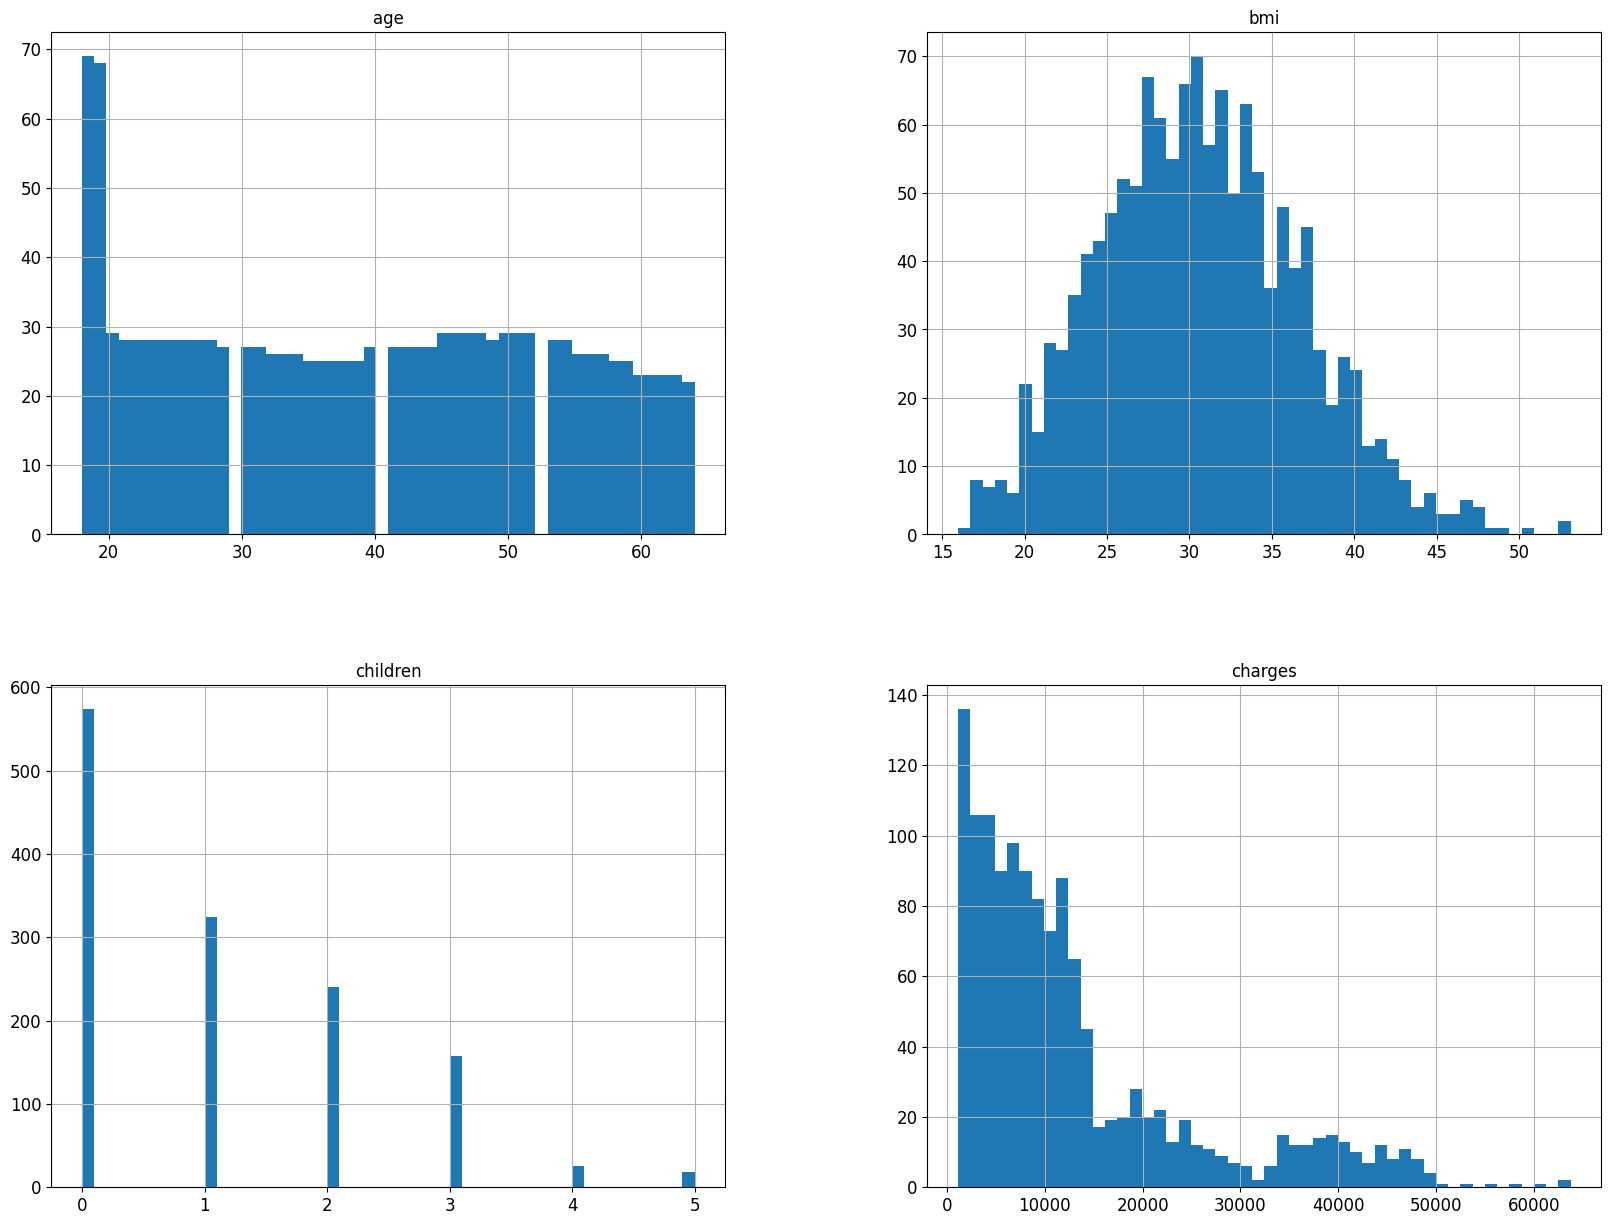

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))

Observações:

- No gráfico de idade (age) percebe-se que é a distribuição é quase igual de 20 a 60 anos, tendo uma concentraçaõ em 18 e 19 anos.
- No histograma de imc (bci) observa-se que está simétrico, tendo uma média em 30.
- A variável de crianças (children) tem uma concentração maior em 0, e os registros vão diminuindo quando a quantidade de crianças aumenta.
- A variável charges (despesas) é nossa target. Tem uma concentração grande de registros antes do 10.000 dólares, e seus dados vão até 64.000 dólares, mas com poucos registros depois dos 50.000.
- É possível observar bastante assimetria nos dados.

#### Separando o dataset em variáveis categóricas e numéricas

In [8]:
categorical_columns = dataset.select_dtypes(include=object).columns.tolist()
numerical_columns = dataset.select_dtypes(exclude=object).columns.tolist()

In [9]:
correlation_matrix = dataset[numerical_columns].corr().round(4)
correlation_matrix

,age,bmi,children,charges
age,1.0000,0.1093,0.0425,0.2990
bmi,0.1093,1.0000,0.0128,0.1983
children,0.0425,0.0128,1.0000,0.0680
charges,0.2990,0.1983,0.0680,1.0000


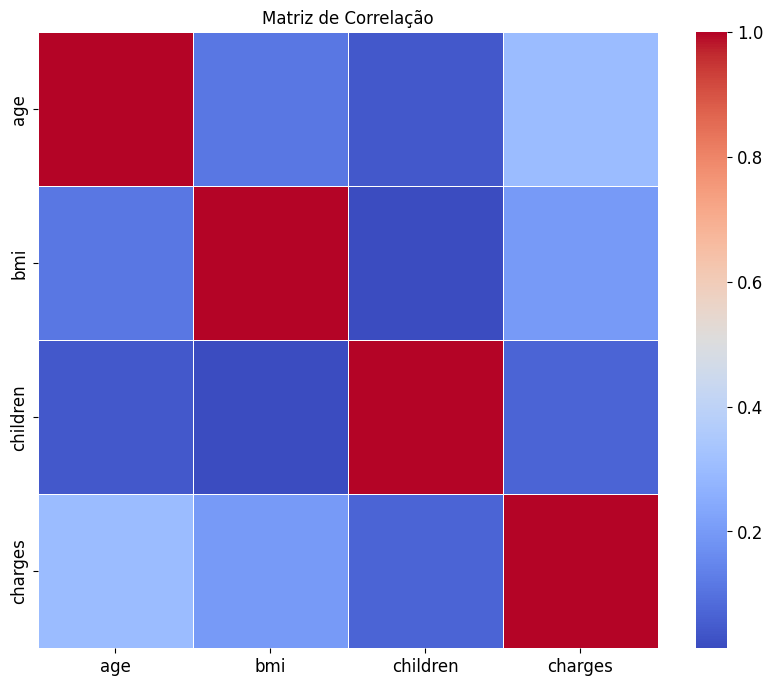

In [10]:
import seaborn as sns

# Visualização da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

Observa-se que nenhuma das variáveis numéricas tem muita correlação. Idade é uma das que tem um pouco mais, porém ainda menor do que 0.5.

Uma hipótese para isso é a escala das variáveis ser muito diferentes. Vamos analisar e validar essa hipótese mais abaixo.

## 2. Pré-processamento de dados

- Realizar limpeza dos dados, tratando valores ausentes (se necessário).
- Converter variáveis categóricas em formatos adequados para modelagem.

Existem 3 variávies que não são numéricas, vamos analisar essas 3 variáveis categóricas: SEX, SMOKER e REGION.

In [11]:
print("Sex: ", set(dataset["sex"]))
print("Smoker: ", set(dataset["smoker"]))
print("Region: ", set(dataset["region"]))

Sex:  {'male', 'female'}
Smoker:  {'yes', 'no'}
Region:  {'northwest', 'southeast', 'southwest', 'northeast'}


In [12]:
dataset["sex"].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [13]:
dataset["smoker"].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [14]:
dataset["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

Faremos a conversão das variáveis categóricas: sex, smoker e region para observarmos se elas tem alguma correlação com as outras variáveis e com a nossa target - charges.

In [15]:
categorical_columns

['sex', 'smoker', 'region']

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Ajustar e transformar os rótulos
dataset['sex'] = label_encoder.fit_transform(dataset['sex'])
dataset['smoker'] = label_encoder.fit_transform(dataset['smoker'])
dataset['region'] = label_encoder.fit_transform(dataset['region'])

dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [17]:
dataset.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


Agora que as variáveis categóricas foram transformadas em numéricas, vamos avaliar o dataset novamente.

In [18]:
correlacao = dataset.corr()

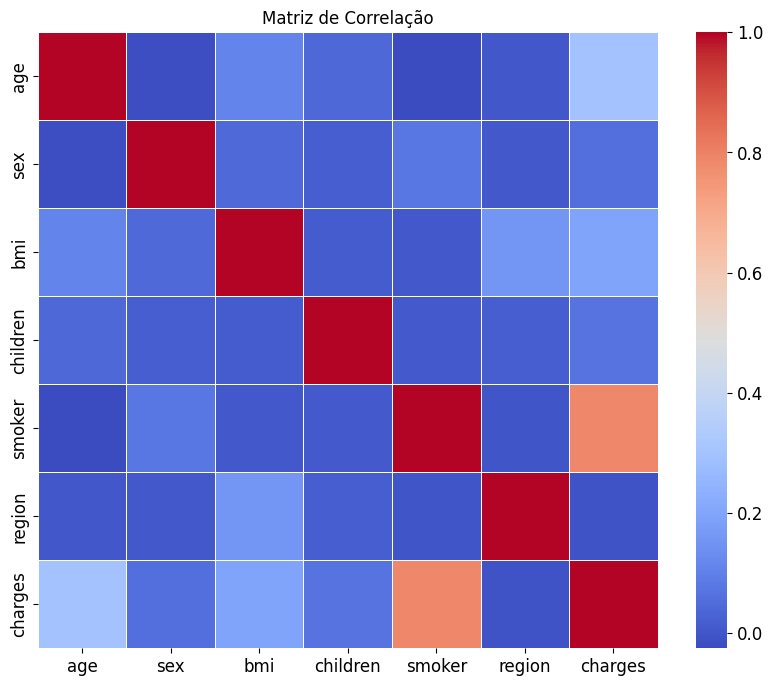

In [19]:
# Visualização da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

- Observa-se que a variável smoker tem uma correlação com a nossa target.

## 3. Modelagem

- Criar um modelo preditivo de regressão (Regressão Linear, Árvores de Decisão, etc)
- Dividir o conjunto de dados em conjuntos de treinamento e teste.

In [20]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em conjuntos de treinamento e teste
x = dataset.drop(['charges'], axis=1)  # Variáveis características
y = dataset['charges'] # O que eu quero prever. (Target)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
treino = len(X_train)
teste = len(X_test)
print(f"Treinamento: {treino} linhas")
print(f"Teste: {teste} linhas")

Treinamento: 1070 linhas
Teste: 268 linhas


## 4. Treinamento e avaliação do modelo

- Treinar o modelo com o conjunto de treinamento

### 4.1 Regressão Linear

In [22]:

# Criando e treinando o modelo de regressão linear
from sklearn.linear_model import LinearRegression


modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
previsoes = modelo.predict(X_test)

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

In [24]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [25]:
# Previsão
y_pred = lin_reg.predict(X_test)
y_pred[0]

8924.407244424494

#### Validação do modelo

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Dataset sem normalização ou padronização")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {(r2 * 100).round(2)}% ")

Dataset sem normalização ou padronização
Mean Squared Error: 33635210.431178406
R2 Score: 78.33% 


## 5. Validação estatística

- Apresentar resultados visuais, como gráficos de previsões vs. valores reais.
- Análise de resultados, insights obtidos e validação estatística.

In [27]:
y_pred_train = lin_reg.predict(X_train)

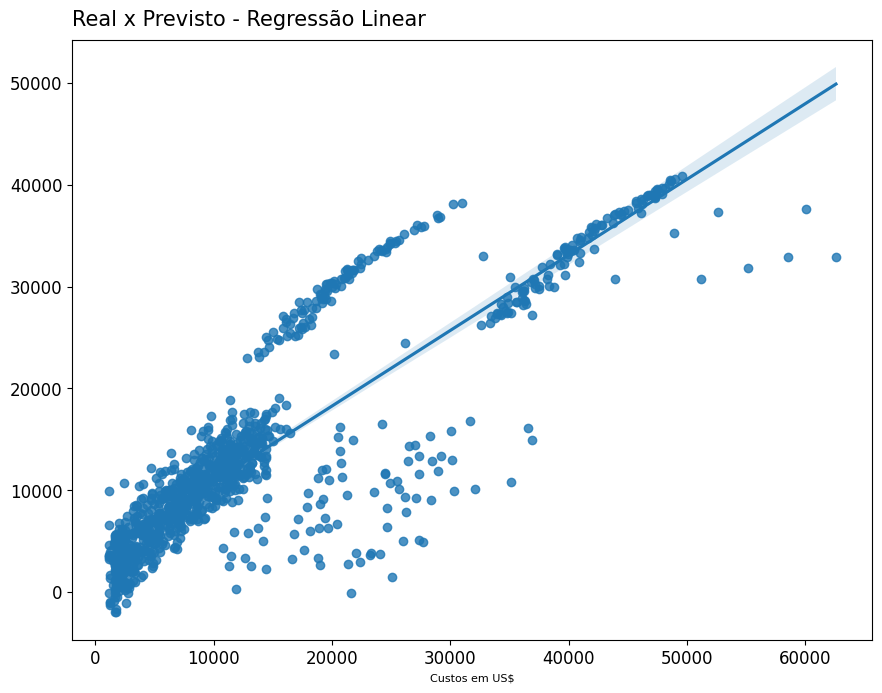

In [28]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_axes([0, 0, 1, 1])

sns.regplot(x = y_train, y = y_pred_train)
ax.set_title('Real x Previsto - Regressão Linear', loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel('Custos em US$', fontsize = 8)
plt.show()